In [1]:
import os

import torch
import numpy as np
import pandas as pd

from retinanet import model, val
from PIL import Image
import PIL
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline

In [2]:
tag = 'debug'
split_name = 'voc-1'
depth = 50
date_time = "20190516_175626"

eval_result_path = './result/{}_{}_{}_{}'.format(
    tag,
    depth,
    split_name,
    date_time
)

img_root_path = "/home/voyager/data/root"
img_path = os.path.join(img_root_path, "voc/JPEGImages")

scale = 1.2
manual_annotation = "bbox_score.csv"
detection = "151_0.3333_2_0.9_4.csv"

In [4]:
# get the result from manual annotation
img_pd = pd.read_csv(os.path.join(img_root_path, manual_annotation))
result_path = os.path.join(img_root_path, "manual_crop")

In [3]:
# get the result path from detection 
img_pd = pd.read_csv(os.path.join(eval_result_path, detection))
result_path = os.path.join(img_root_path, "detection_crop")

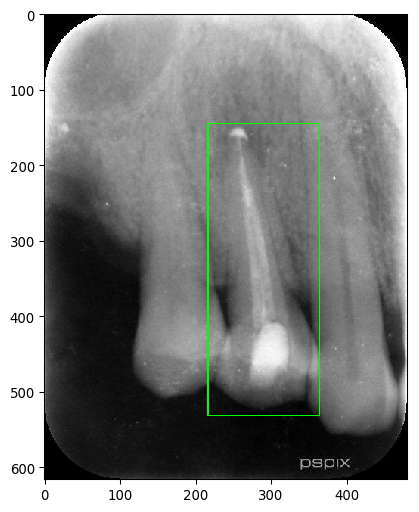

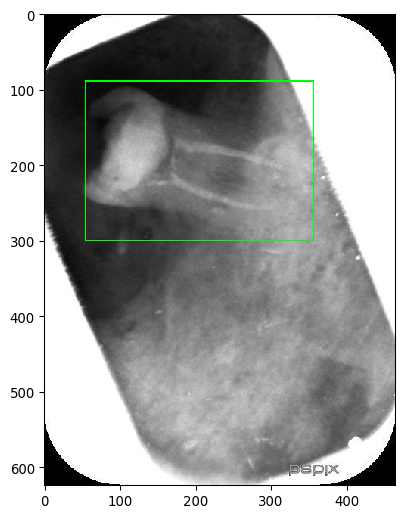

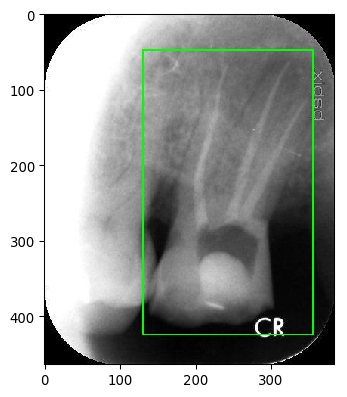

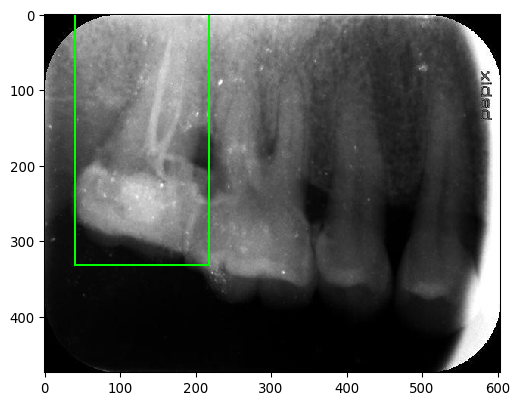

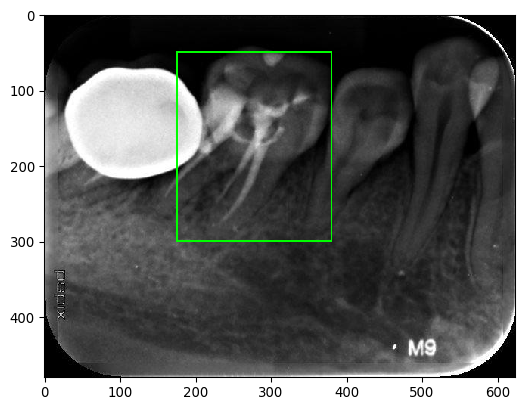

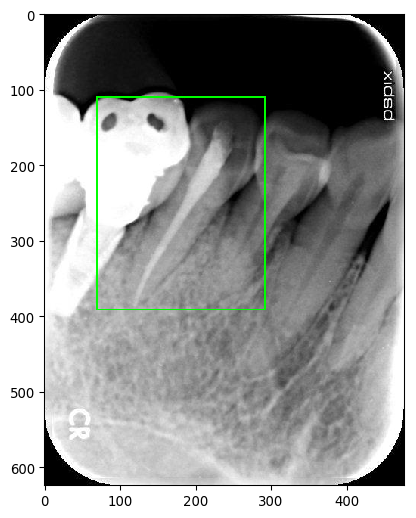

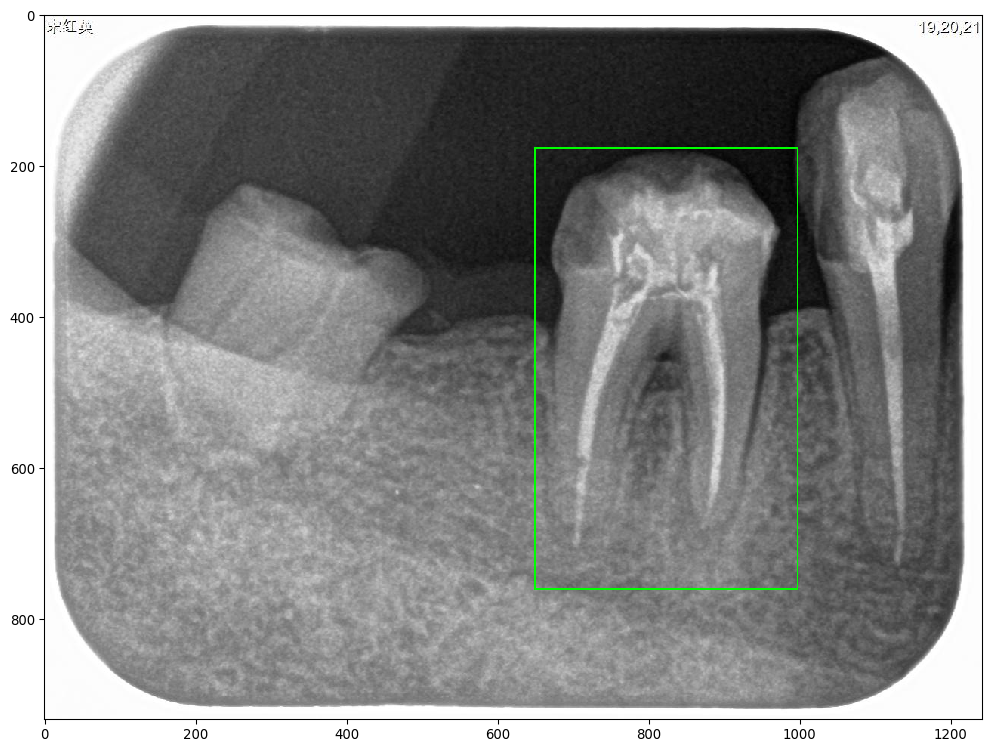

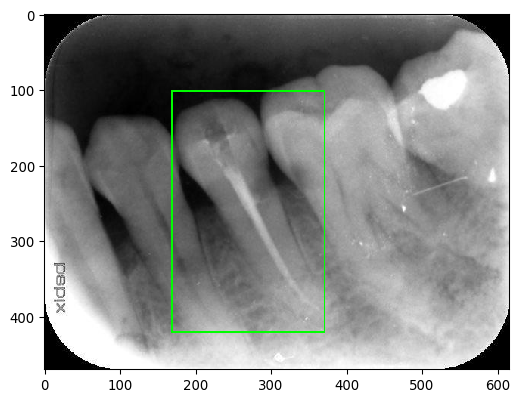

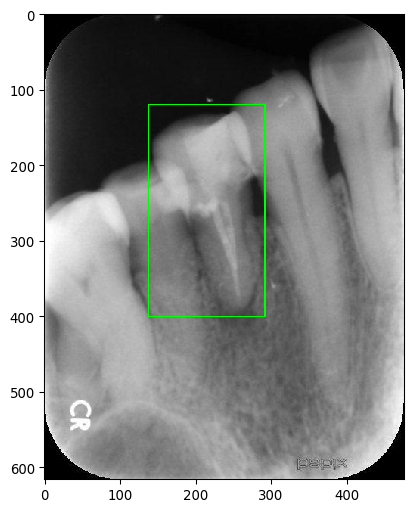

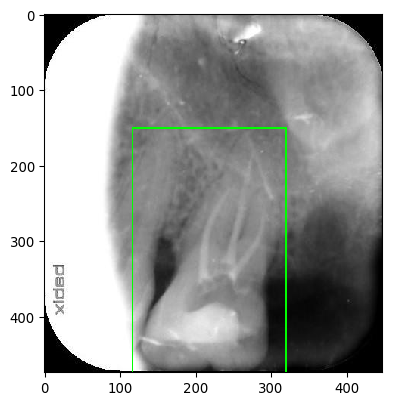

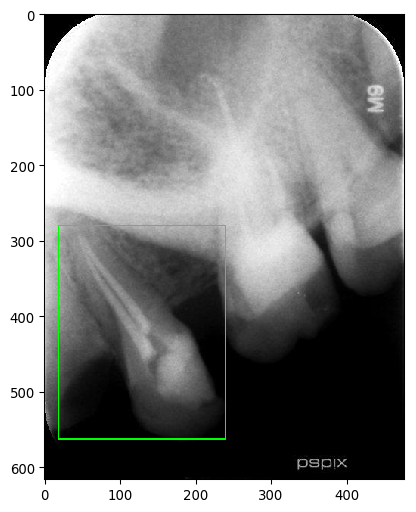

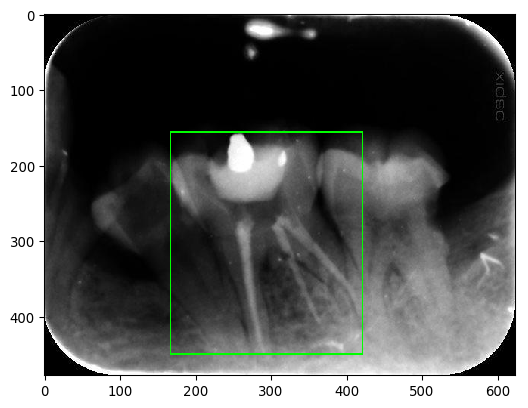

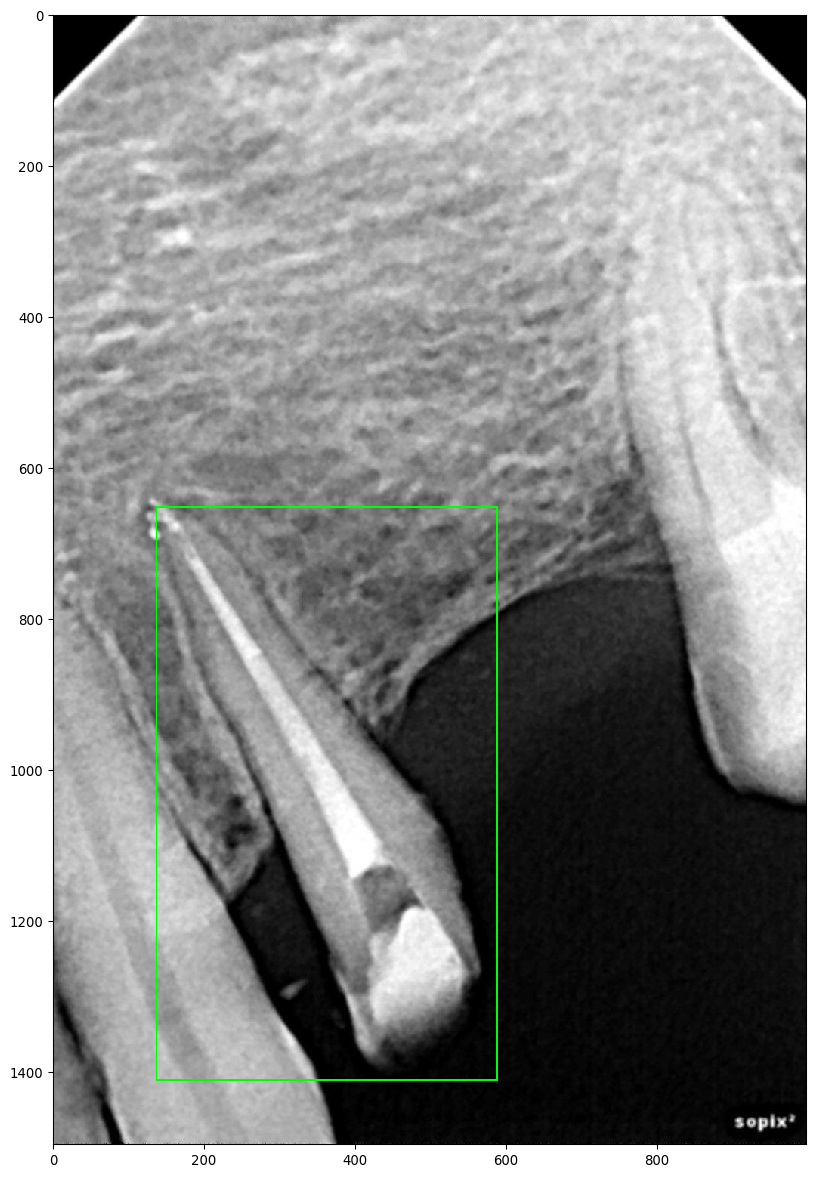

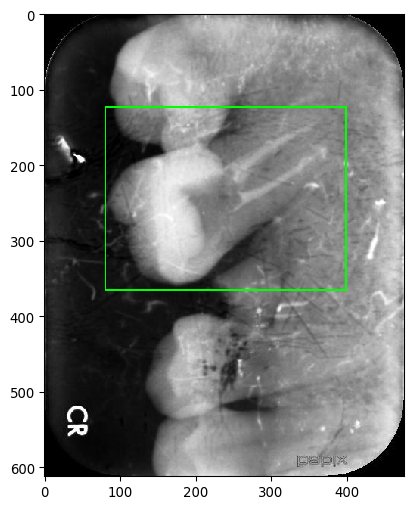

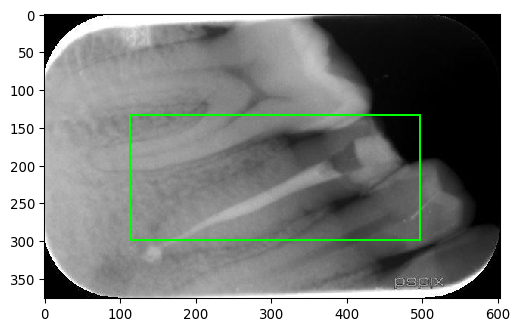

In [4]:
# draw boxes on images 
def draw_bbox(img, anno):
    # draw anno on PIL img
    gts = anno[1].numpy()
    np_img = np.asarray(img)
    
    bbs = []
    for gt in gts:
        bbs.append(BoundingBox(x1=gt[0], y1=gt[1], x2=gt[2], y2=gt[3]))

    bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
    draw_img = bbs_on_img.draw_on_image(np_img, size=2)
    # draw_img is a ndarray
    ia.imshow(draw_img)
    
def draw_all_img(img_pd, img_path=None):
    # get the img dataframe and origin image path, and draw boxes on images
    for index in range(img_pd.shape[0]):
        img = img_pd.iloc[index]
        
        img_id = img['id']
        label = img['class']
        x1 = img['x1']
        y1 = img['y1']
        x2 = img['x2']
        y2 = img['y2']
        
        img = Image.open(os.path.join(img_path, img_id + ".jpg"))
        anno = (torch.IntTensor([label]), torch.tensor([[x1, y1, x2, y2]]))
        draw_bbox(img, anno)

draw_all_img(img_pd[0:15], img_path=img_path)

In [5]:
def save_crop_box(img_pd, img_path=None, result_path=None, scale=1):
    # crop box on images which under img_path, and save under result_path, following img_pd's guide.
    #  Scale control the size ratio between new and old images.
    for index in range(img_pd.shape[0]):
        img = img_pd.iloc[index]
        
        uid = img['id']
        serial = img['serial']
        x1 = img['x1']
        y1 = img['y1']
        x2 = img['x2']
        y2 = img['y2']
        deltaw = (x2 - x1) * (scale - 1) / 2
        x1 -= deltaw
        x2 += deltaw
        deltah = (y2 - y1) * (scale - 1) / 2
        y1 -= deltah
        y2 += deltah
        
        img = Image.open(os.path.join(img_path, uid + ".jpg"))
        
        # box – The crop rectangle, as a (left, upper, right, lower)-tuple
        box = (x1, y1, x2, y2)
        file_name = os.path.join(result_path, '{}_{}.jpg'.format(uid, serial))
        
        box = img.crop(box).save(file_name)
        
        
save_crop_box(img_pd[:], img_path=img_path, result_path=result_path, scale=scale)